# Trabajo Práctico 3
## Visión por computadora
### Universidad de Buenos Aires

---
**Alumnas**: 
- Espínola, Carla
- Gambarte, Antonella Nerea

In [263]:
#!pip install opencv-contrib-python
#!pip install supervision

In [264]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import supervision as sv

In [322]:
template_path = './template/pattern.png'
template = cv.imread(template_path, 0)
w, h = template.shape[::-1]

image_paths = glob.glob('./images/*.png') + glob.glob('./images/*.jpg')

### Estrategias de mejoras para detección de logos

A continuación se detallan distintas estrategias de preprocesamiento utilizadas para la robustez y precisión de la detección del logo de coca cola en las imagenes provistas.

- Recorte manual: Se elimina el borde del template para evitar que zonas irrelevantes influyan en la detección. Esto ayuda a centrar la búsqueda en la región más representativa del logo.

- Mejora del contraste (CLAHE): se aplica la técnica CLAHE tanto a la imagen como a la plantilla para mejorar el contraste. Esto ayuda a mejorar la visibilidad de los detalles y características del logo en la imagen.

- Escalado:** Se modifica el tamaño del template para simular posibles variaciones en las imágenes reales. Esto permite que el algoritmo sea más tolerante a cambios de escala en la aparición del logo.

- Blur y Laplaciano: se aplica un Gaussian Blur para suavizar las imágenes y reducir el ruido, lo que ayuda a que el filtro Laplaciano se enfoque en las características de la imagen sin ser afectado por detalles irrelevantes. El filtro Laplaciano resalta las áreas de alto contraste, que son las que probablemente contengan las características más importantes del logo.

- Variante de color: Se invierte el color del template para simular situaciones donde el logo aparece con diferente fondo o color. Esta estrategia mejora la detección ante cambios de color o inversión de tonos.

- Bordes con Canny: Se extraen los bordes principales del template usando el detector de Canny. Esto enfatiza las formas y contornos, facilitando la coincidencia basada en geometría y estructura.

- Eliminación de ruido (mediana): Se aplica un filtro de mediana para reducir el ruido y suavizar la imagen, lo que ayuda a evitar falsas detecciones causadas por píxeles aislados o artefactos.

- Umbralización : se aplica un umbral binario para eliminar los valores de píxeles bajos que no aportan información significativa.

- Template Matching: la plantilla se escala en varios tamaños para detectar el logo a diferentes escalas en la imagen.

- Non-Maximum Suppression (NMS): se aplica para eliminar las detecciones redundantes y solapadas. Solo se mantiene la detección con la puntuación más alta para cada área.

- Filtrado por Harris: se aplica para verificar que las regiones detectadas contengan suficientes esquinas fuertes, lo que indica que son características clave de la imagen y no simplemente ruido.

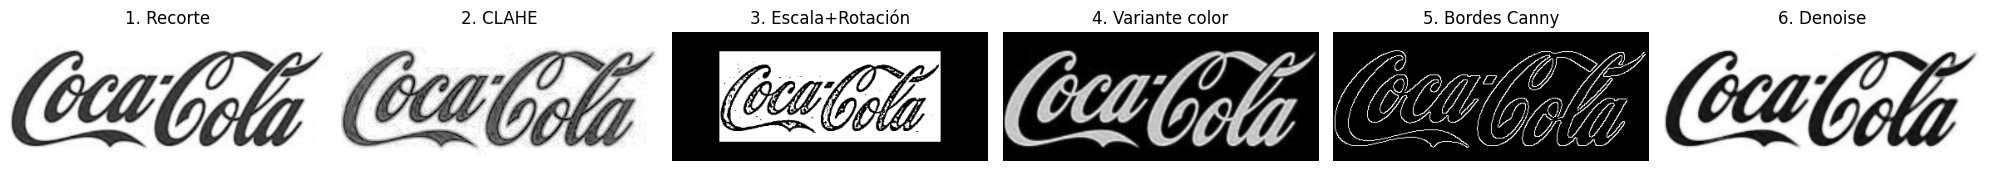

In [306]:
# Algunas pruebas

template_path = './template/pattern.png'
template_orig = cv.imread(template_path, 0)

fig, axs = plt.subplots(1, 6, figsize=(20, 15))
axs = axs.flatten()

# 1. Recorte manual: se recorta el templa

template_crop = template_orig[10:-10, 10:-10]
axs[0].imshow(template_crop, cmap='gray')
axs[0].set_title('1. Recorte')
axs[0].axis('off')

# 2. Mejora de contraste (CLAHE)
clahe = cv.createCLAHE(clipLimit=4.0, tileGridSize=(7,7))
template_clahe = clahe.apply(template_crop)
axs[1].imshow(template_clahe, cmap='gray')
axs[1].set_title('2. CLAHE')
axs[1].axis('off')

# 3. Escalado y rotación (ejemplo: escala 0.7 y rotación 15°)
scale = 0.7
rot_angle = 0
M = cv.getRotationMatrix2D((template_bin.shape[1]//2, template_bin.shape[0]//2), rot_angle, scale)
template_trans = cv.warpAffine(template_bin, M, (template_bin.shape[1], template_bin.shape[0]))
axs[2].imshow(template_trans, cmap='gray')
axs[2].set_title('3. Escala+Rotación')
axs[2].axis('off')

# 4. Variante de color (simulado: invertimos el binario)
template_color_var = cv.bitwise_not(template_crop)
axs[3].imshow(template_color_var, cmap='gray')
axs[3].set_title('4. Variante color')
axs[3].axis('off')

# 6. Bordes con Canny
template_canny = cv.Canny(template_crop, 80, 160)
axs[4].imshow(template_canny, cmap='gray')
axs[4].set_title('5. Bordes Canny')
axs[4].axis('off')

# 6. Eliminación de ruido (mediana)
template_denoise = cv.medianBlur(template_crop, 5)
axs[5].imshow(template_denoise, cmap='gray')
axs[5].set_title('6. Denoise')
axs[5].axis('off')

plt.tight_layout()
plt.show()

### 1. Obtener una detección del logo en cada imagen sin falsos positivos

In [330]:
def resize_images_to_scale(img, target_width=800):
    if img is None:
        print("No se pudo leer la imagen.")
        return None
    h, w = img.shape[:2]
    scale = target_width / w
    new_dim = (target_width, int(h * scale))
    img_resized = cv.resize(img, new_dim, interpolation=cv.INTER_AREA)
    return img_resized

def preprocesar_imagen(imagen, usar_recorte=True, usar_canny=False, usar_laplacian=True, usar_gaussian=True, usar_clahe=True,
        usar_variacion_color=True, eliminar_ruido=True,
        usar_umbralizacion=False):

    if usar_recorte:
        imagen = imagen[10:-10, 8:-10]

    if usar_clahe:
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        imagen = clahe.apply(imagen)

    if usar_variacion_color:
        imagen = cv.bitwise_not(imagen)

    if eliminar_ruido:
        #imagen = cv.fastNlMeansDenoisingColored(imagen, None, 10, 10, 7, 21)
        imagen = cv.medianBlur(imagen, 5)

    if usar_gaussian:
        #imagen = cv.GaussianBlur(imagen, (5, 5), 0)
        imagen = cv.GaussianBlur(imagen, (3, 3), 0)

    if usar_laplacian:
        imagen = cv.Laplacian(imagen, cv.CV_64F, ksize=3)
        imagen = cv.convertScaleAbs(imagen)

    if usar_canny:
        #imagen = cv.Canny(imagen, 100, 200)
        imagen = cv.Canny(imagen, 80, 160)

    if usar_umbralizacion:
        _, imagen = cv.threshold(imagen, 10, 255, cv.THRESH_BINARY)
    
    return imagen

def mostrar_resultados(mejor_deteccion, img_rgb, lap_tpl, mostrar_matches):
    dst, good, mask, escala, lap_img, kp1, kp2 = mejor_deteccion
    img_detected = cv.polylines(img_rgb, [np.int32(dst)], True, (0,255,0), 3, cv.LINE_AA)
    plt.figure(figsize=(10,6))
    plt.imshow(cv.cvtColor(img_detected, cv.COLOR_BGR2RGB))
    plt.title(f"Logo detectado (escala {escala}, {len(good)} coincidencias)")
    plt.axis("off")
    plt.show()

    if mostrar_matches:
        matchesMask = mask.ravel().tolist()
        draw_params = dict(matchColor=(0,255,0),
                            singlePointColor=None,
                            matchesMask=matchesMask,
                            flags=2)
        match_img = cv.drawMatches(lap_tpl, kp1, lap_img, kp2, good, None, **draw_params)
        #sv.plot_image(match_img)
        plt.figure(figsize=(12,6))
        plt.imshow(match_img, cmap='gray')
        plt.title("Coincidencias SIFT + FLANN")
        plt.axis("off")
        plt.show()

In [331]:
def detectar_logo_sift_multiescala(
        imagen_path, template, min_match_count=4, 
        usar_canny=False, usar_laplacian=True, usar_gaussian=True, usar_clahe=True, usar_recorte=True, 
        usar_variacion_color=True, eliminar_ruido=True,
        mostrar_matches=False, min_scale=0.2, amount_scales=10, ratio_test=0.75):
    
    img_rgb = cv.imread(imagen_path)
    if img_rgb is None:
        print(f"No se pudo leer la imagen {imagen_path}")
        return

    #img_rgb = resize_images_to_scale(img_rgb, target_width=1200)

    img_gray_original = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
    template_gray_original = cv.cvtColor(template, cv.COLOR_BGR2GRAY) if len(template.shape) == 3 else template

    lap_img = preprocesar_imagen(img_gray_original, usar_recorte=usar_recorte, usar_canny=usar_canny, usar_laplacian=usar_laplacian, usar_gaussian=usar_gaussian, usar_clahe=usar_clahe,
        usar_variacion_color=usar_variacion_color, eliminar_ruido=eliminar_ruido)
    lap_tpl = preprocesar_imagen(template_gray_original, usar_recorte=usar_recorte, usar_canny=usar_canny, usar_laplacian=usar_laplacian, usar_gaussian=usar_gaussian, usar_clahe=usar_clahe,
        usar_variacion_color=usar_variacion_color, eliminar_ruido=eliminar_ruido, usar_umbralizacion=False)
    
    sift = cv.SIFT_create(nfeatures=3000)
    mejor_deteccion = None
    max_good_matches = 0

    img_h, img_w = lap_img.shape
    t_h, t_w = lap_tpl.shape

    # Escalas
    max_scale = max(min(img_w / t_w, img_h / t_h), min_scale)
    escalas = np.linspace(min_scale, max_scale, amount_scales)
    
    # --- Multi-escala ---
    for escala in escalas:
        w_s = int(t_w * escala)
        h_s = int(t_h * escala)
        if w_s < 10 or h_s < 10 or w_s > img_w or h_s > img_h:
            continue
        
        tpl_resized = cv.resize(lap_tpl, (w_s, h_s), interpolation=cv.INTER_AREA)

        kp1, des1 = sift.detectAndCompute(tpl_resized, None)
        kp2, des2 = sift.detectAndCompute(lap_img, None)
        if des1 is None or des2 is None:
            continue

        # FLANN
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1, des2, k=2)

        # Ratio test parametrizable
        good = [m for m,n in matches if m.distance < ratio_test * n.distance]

        if len(good) < min_match_count or len(good) < 4:
            continue

        # Homografía
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
        if M is None:
            continue

        # Transformar puntos del template
        h, w = lap_tpl.shape
        pts = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2)
        dst = cv.perspectiveTransform(pts, M)

        # Filtro por área
        area = cv.contourArea(dst)
        if area < 0.001 * lap_img.shape[0] * lap_img.shape[1]:
            continue

        # Guardar la mejor detección (más coincidencias buenas)
        if len(good) > max_good_matches:
            max_good_matches = len(good)
            mejor_deteccion = (dst, good, mask, escala, lap_img, kp1, kp2)

    # Mostrar resultado
    if mejor_deteccion is not None:
        mostrar_resultados(mejor_deteccion, img_rgb, lap_tpl, mostrar_matches)
    else:
        print(f"No se detectó el logo en {imagen_path}")


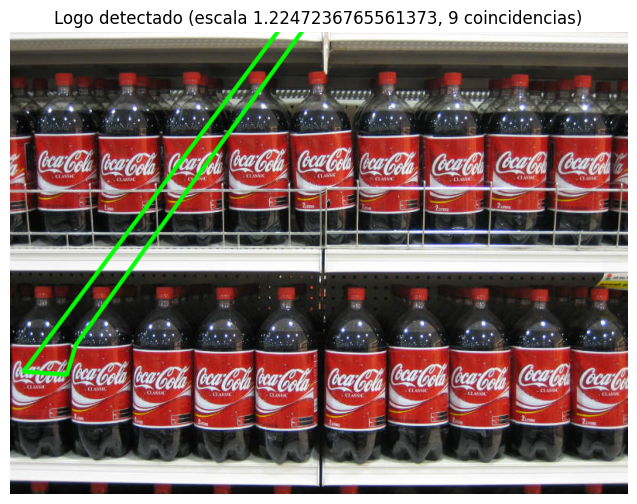

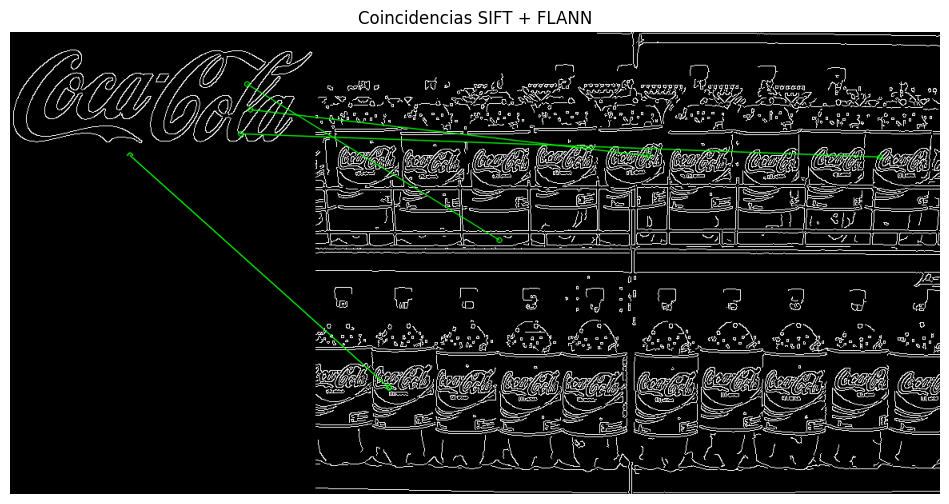

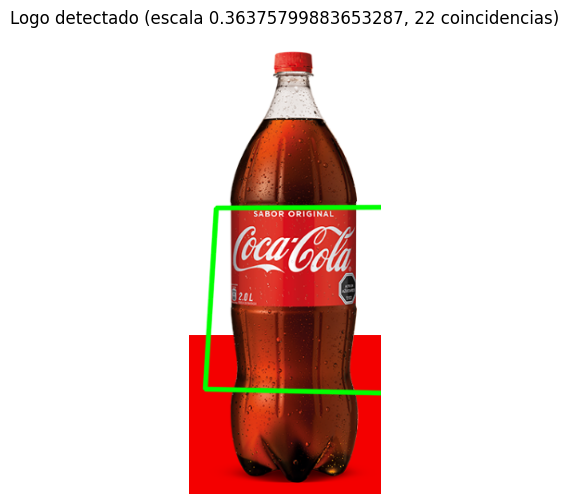

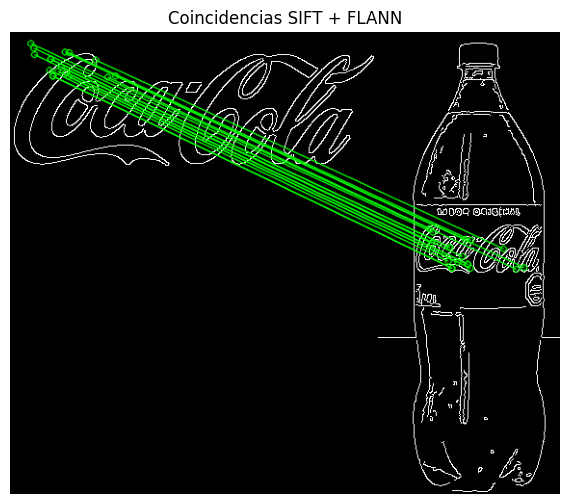

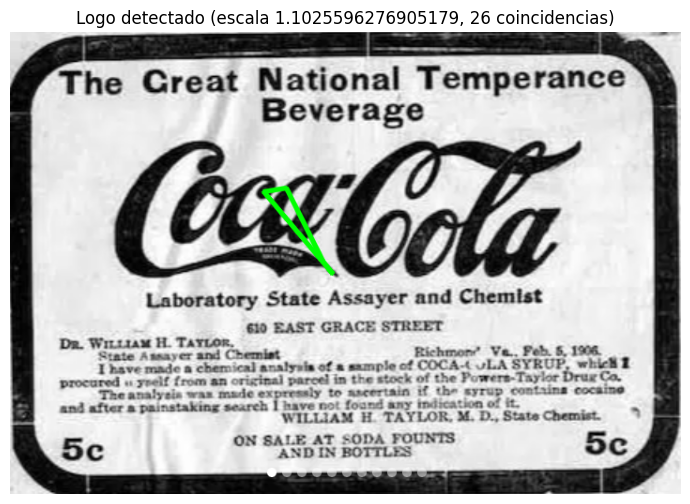

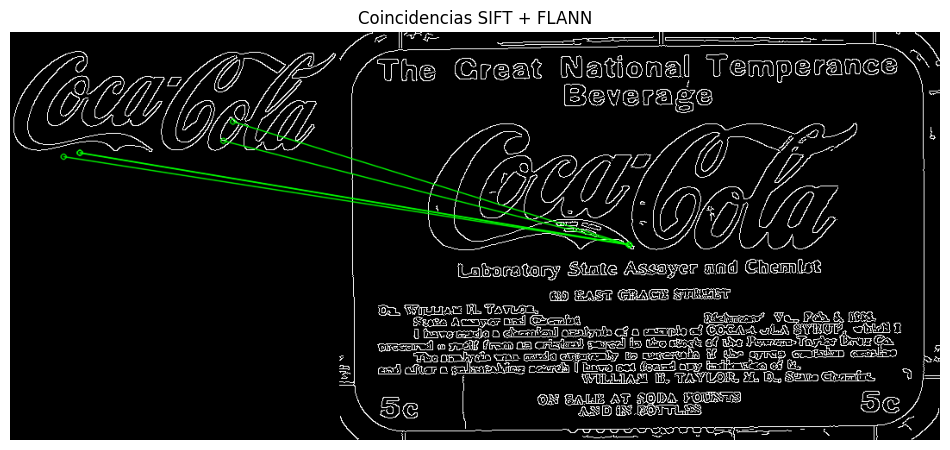

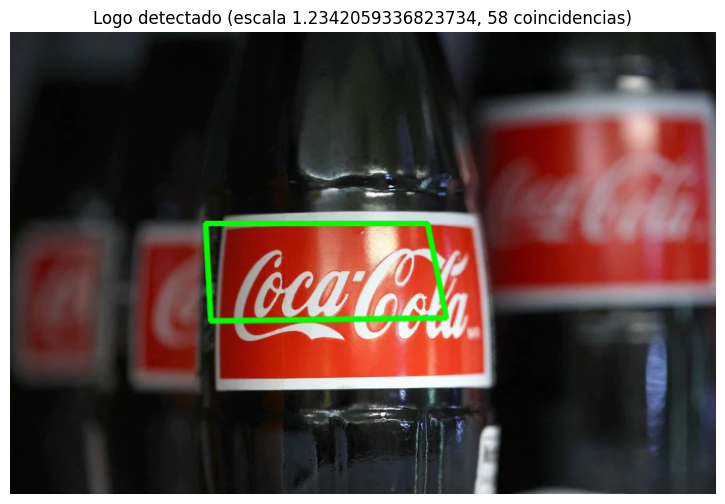

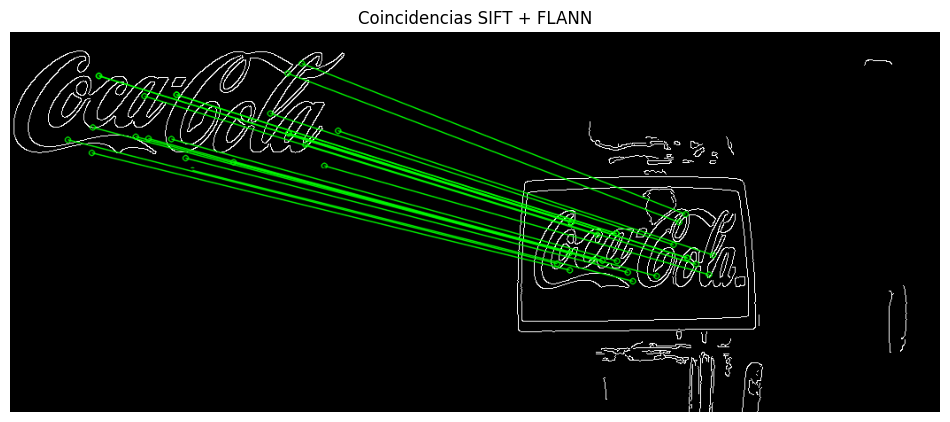

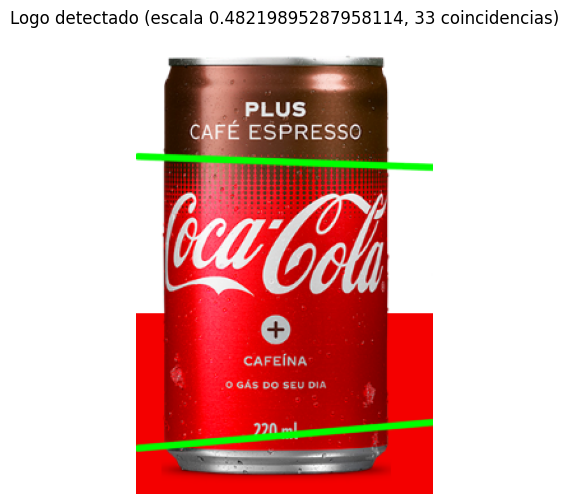

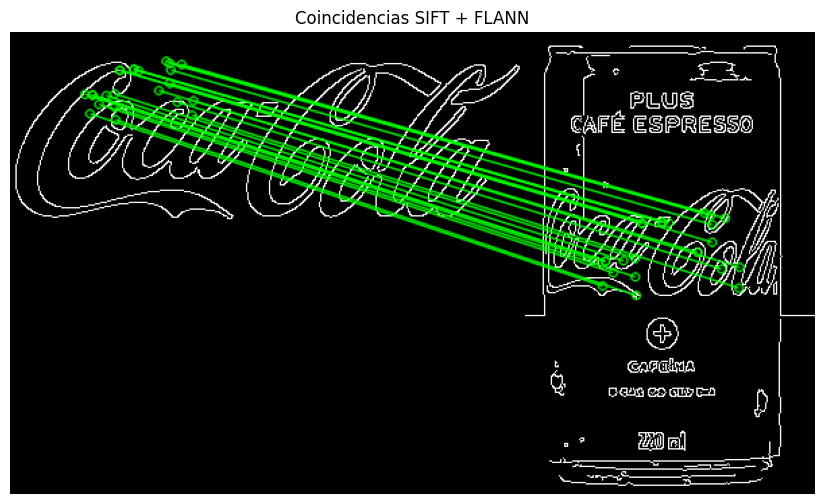

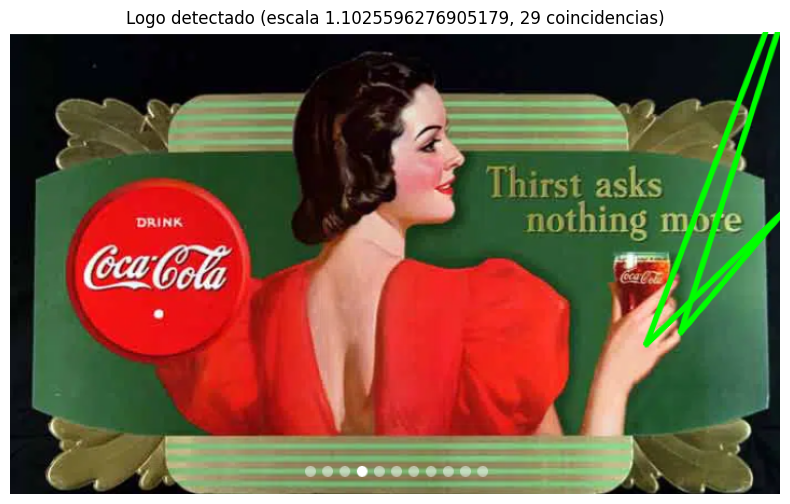

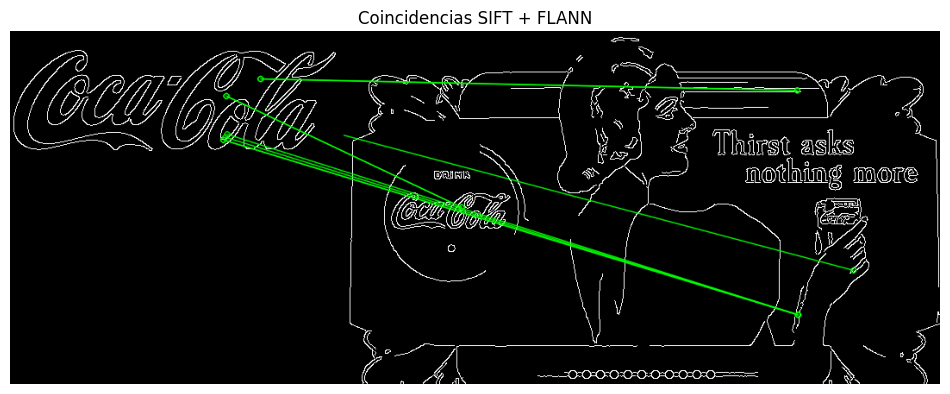

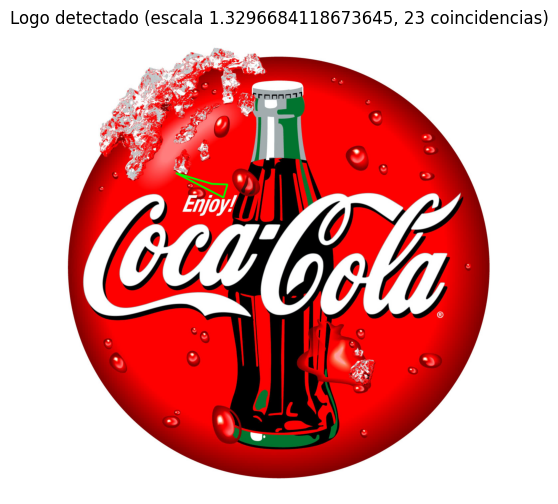

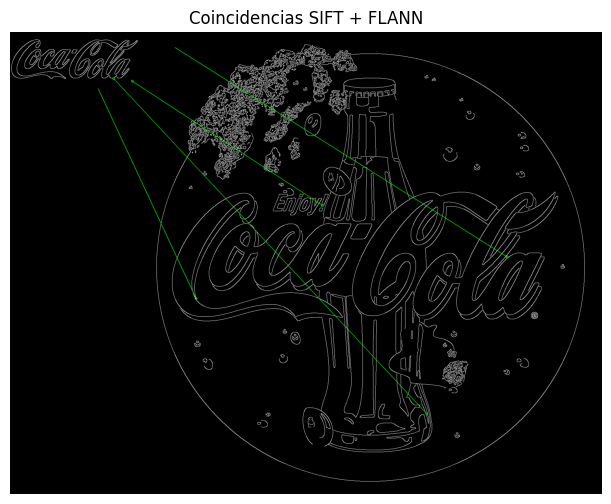

In [332]:
for img_path in image_paths:
    detectar_logo_sift_multiescala(
        img_path, template, min_match_count=4, 
        usar_canny=True, usar_laplacian=False, eliminar_ruido=False, 
        usar_gaussian=True, usar_clahe=False, 
        usar_recorte=True, usar_variacion_color=True, 
        mostrar_matches=True, ratio_test=0.80)

### 2. Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1

Para la detección multiple del logo se aplicó Template Matching, utilizando Laplaciano y mejoras adicionales como CLAHE , Gaussian Blur y Non-Maximum Suppression (NMS).

In [324]:
def detect_multi_logo(path, min_scale=0.2, amount_scales=10, method=cv.TM_CCORR_NORMED, threshold=0.96, 
 nms_overlap_thresh=0.3, harris_min_corners_ratio=0.15, min_score=0.9):
   
    # --- Carga de imagen y template ---
    img = cv.imread(path)
    tpl = cv.imread('template/pattern.png', 0)

    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # --- CLAHE para mejorar contraste ---
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_eq = clahe.apply(img_gray)
    tpl_eq = clahe.apply(tpl)

    # --- Blur para suavizar imágenes y Laplaciano ---
    img_blur = cv.GaussianBlur(img_eq, (3,3), 0)
    tpl_blur = cv.GaussianBlur(tpl_eq, (3,3), 0)

    lap_img = cv.Laplacian(img_blur, cv.CV_64F, ksize=3)
    lap_img = cv.convertScaleAbs(lap_img)

    lap_tpl = cv.Laplacian(tpl_blur, cv.CV_64F, ksize=3)
    lap_tpl = cv.convertScaleAbs(lap_tpl)

    # --- Umbralización para eliminar ruido ---
    _, lap_img = cv.threshold(lap_img, 10, 255, cv.THRESH_BINARY)
    _, lap_tpl = cv.threshold(lap_tpl, 10, 255, cv.THRESH_BINARY)

    img_h, img_w = lap_img.shape
    t_h, t_w = lap_tpl.shape

    # Escalas
    max_scale = max(min(img_w / t_w, img_h / t_h), min_scale)
    scales = np.linspace(min_scale, max_scale, amount_scales)

    # --- Template Matching ---
    all_boxes = []
    for scale in scales:
        w_s = int(t_w * scale)
        h_s = int(t_h * scale)
        if w_s < 10 or h_s < 10 or w_s > img_w or h_s > img_h:
            continue

        tpl_resized = cv.resize(lap_tpl, (w_s, h_s), interpolation=cv.INTER_AREA)
        res = cv.matchTemplate(lap_img, tpl_resized, method)

        res_score = cv.normalize(res, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

        # Localizamos picos por threshold
        loc = np.where(res_score >= threshold)
        for pt in zip(*loc[::-1]): 
            x, y = pt
            score = float(res_score[y, x])

            # Filtramos detecciones con puntuaciones bajas antes de NMS
            if score < min_score:
                continue

            all_boxes.append([x, y, x + w_s, y + h_s, score])

    # --- NMS --- 
    nms_boxes = []
    scores = []
    for box in all_boxes:
        x1, y1, x2, y2, score = box
        w = x2 - x1
        h = y2 - y1
        nms_boxes.append([x1, y1, w, h])
        scores.append(score)

    nms_boxes = np.array(nms_boxes)
    scores = np.array(scores)

    nms_indices = cv.dnn.NMSBoxes(nms_boxes.tolist(), scores.tolist(), score_threshold=min_score, nms_threshold=nms_overlap_thresh)

    # Filtramos las cajas finales después de NMS
    final_boxes_with_harris = []
    if len(nms_indices) > 0:
        for i in nms_indices.flatten():
            final_boxes_with_harris.append(all_boxes[i])

    # --- Verificación Harris ---
    final_boxes_filtered = []
    for b in final_boxes_with_harris:
        if len(b) == 5:
            x1, y1, x2, y2, sc = b
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(img_w, x2), min(img_h, y2)
            
            region = img_eq[y1:y2, x1:x2]
            
            if region.size == 0:
                continue

            # Harris
            dst = cv.cornerHarris(np.float32(region), 2, 3, 0.04)

            # Contar las esquinas significativas
            strong_corners = np.sum(dst > 0.01 * dst.max())

            # Filtramos las detecciones que no tienen suficientes esquinas
            min_corners = max(3, int(harris_min_corners_ratio * region.size))
            
            if strong_corners >= min_corners:
                final_boxes_filtered.append((x1, y1, x2, y2, sc))

    # --- Gráfico ---
    img_out = img_rgb.copy()
    for (x1, y1, x2, y2, val) in final_boxes_filtered:
        cv.rectangle(img_out, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv.putText(img_out, f"{val:.2f}", (x1, max(5, y1 - 5)), cv.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 0), 1)

    # Mostrar resultados
    plt.figure(figsize=(8, 8))
    plt.imshow(img_out)
    plt.title(f'Threshold={threshold}')
    plt.axis('off')
    plt.show()

    return img_out, final_boxes_filtered

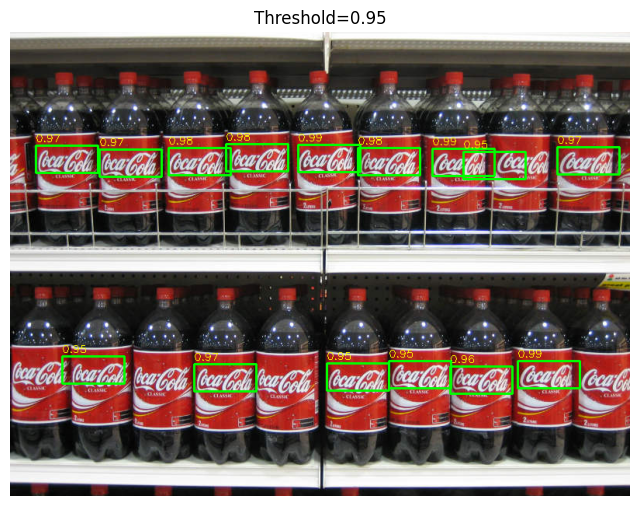

In [325]:
out_img, boxes = detect_multi_logo('images/coca_multi.png', threshold=0.95)

### 3. Generalizar el algoritmo del item 2 para todas las imágenes.

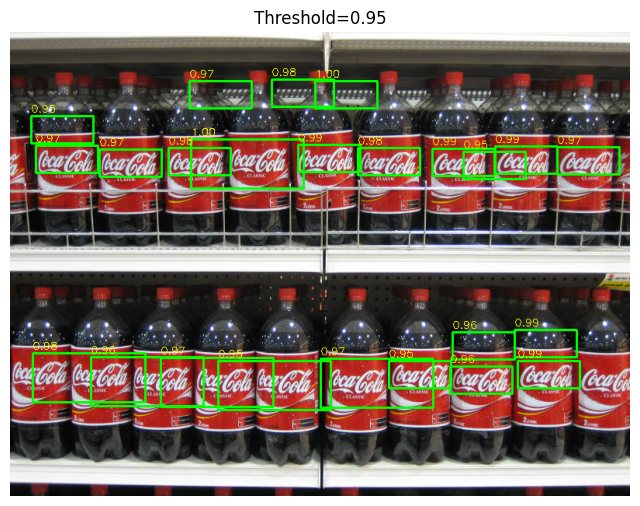

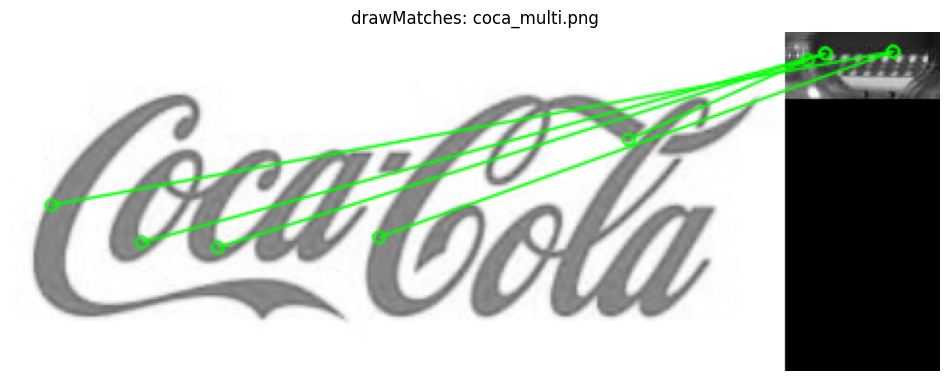

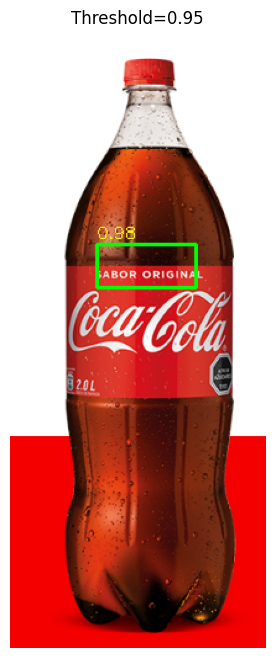

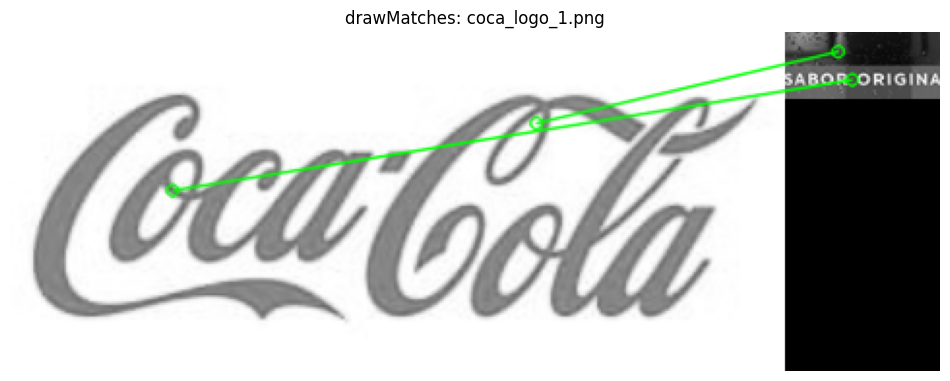

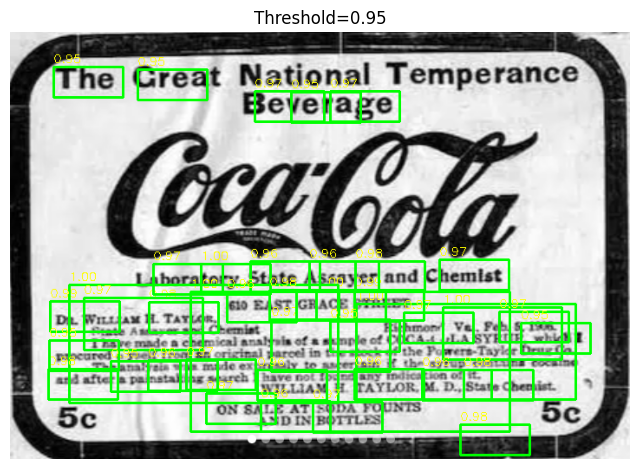

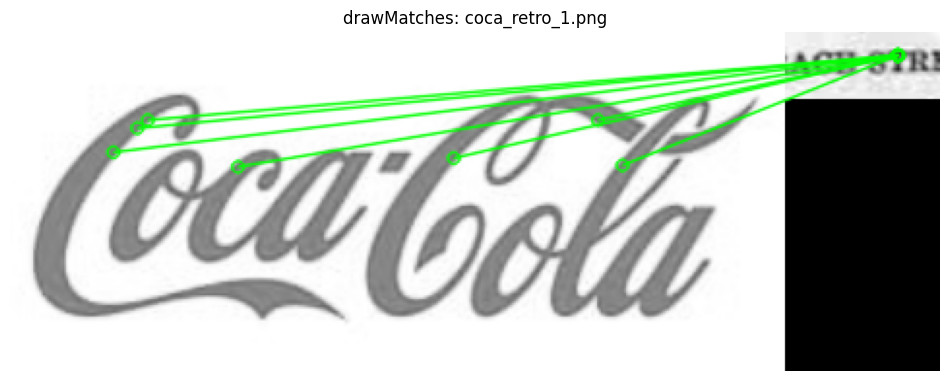

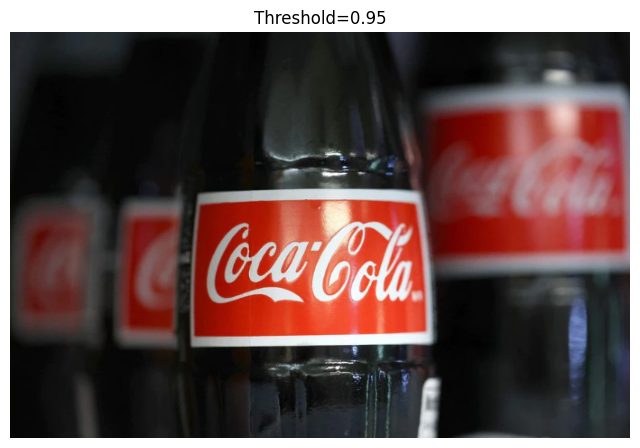

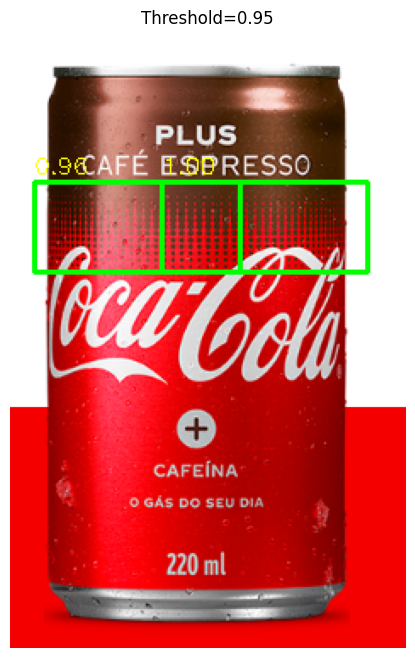

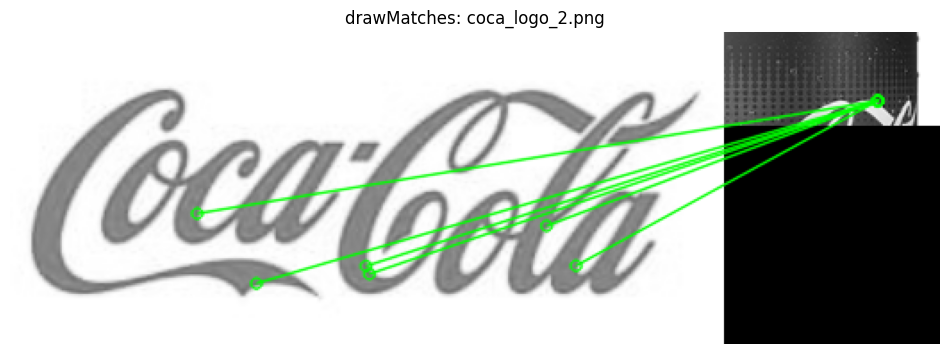

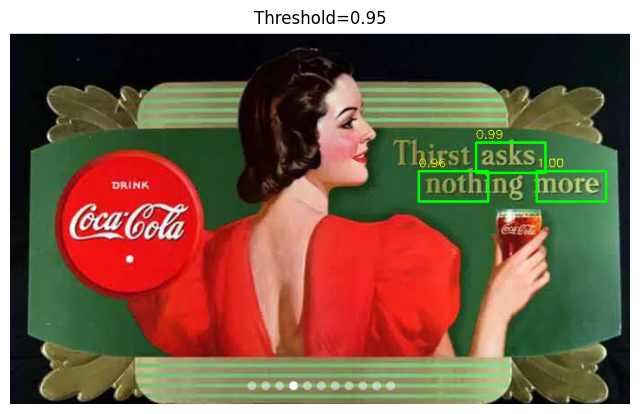

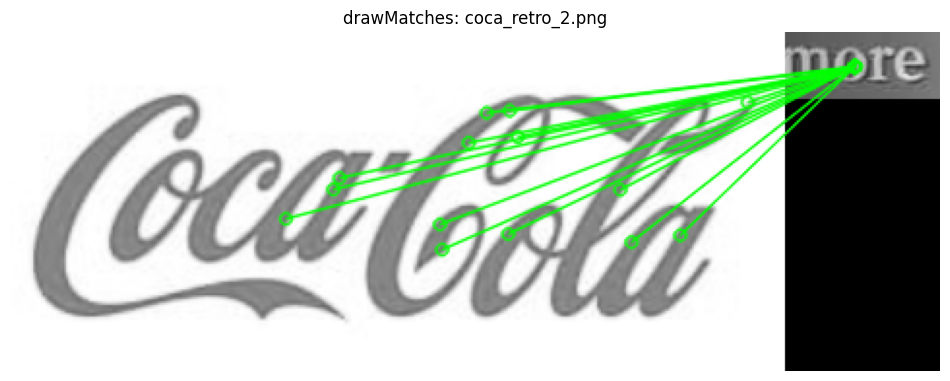

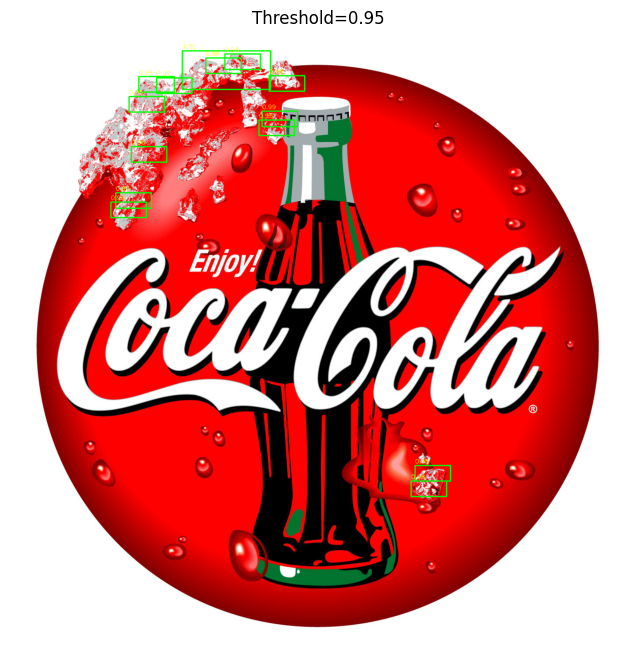

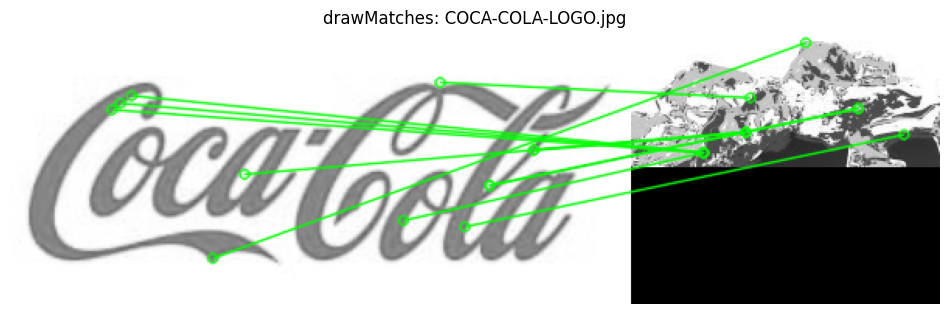

In [ ]:
def detectar_logo_multiescala(imagen_path, template, threshold=0.8, escalas=np.linspace(0.5, 1.5, 10)):
    img_rgb = cv.imread(imagen_path)
    img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
    mejor_conf = -1
    mejor_top_left = None
    mejor_w, mejor_h = 0, 0
    for escala in escalas:
        temp_resized = cv.resize(template, (int(template.shape[1]*escala), int(template.shape[0]*escala)))
        if temp_resized.shape[0] > img_gray.shape[0] or temp_resized.shape[1] > img_gray.shape[1]:
            continue
        #res = cv2.matchTemplate(img_gray, temp_resized, cv2.TM_CCOEFF_NORMED)
        res = cv.matchTemplate(img_gray, temp_resized, cv.TM_CCORR_NORMED)
        #res = cv2.matchTemplate(img_gray, temp_resized, cv2.TM_SQDIFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        if max_val > mejor_conf:
            mejor_conf = max_val
            mejor_top_left = max_loc
            mejor_w, mejor_h = temp_resized.shape[1], temp_resized.shape[0]
    if mejor_conf >= threshold:
        bottom_right = (mejor_top_left[0] + mejor_w, mejor_top_left[1] + mejor_h)
        cv.rectangle(img_rgb, mejor_top_left, bottom_right, (0,255,0), 2)
        plt.imshow(cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB))
        plt.title(f'Confianza: {mejor_conf:.2f}')
        plt.axis('off')
        plt.show()
    else:
        print(f"No se detectó logo en {imagen_path}")